# Intro + Importing the Data
This analysis will be conducted completely in a Jupyter notebook. We have a small dataset of commercial real estate loans and we're going to explore it (including with graphs) and predict loan-to-value (LTV) with machine learning. After cloning the notebook, the only thing you would need to do is put the original dataset in the data folder. <br><br>
Let's import the data and view some of it.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
data = pd.read_csv("data/re_data.csv")
pd.DataFrame.head(data)

,First Payment Date,Maturity Date,Loan Amount,Zip,Property Value,Year Built,Net Operating Income,Effective Gross Income,Total Operating Expenses,Maintenance Expense,Parking Expense,Taxes Expense,Insurance Expense,Utilities Expense,Payroll Expense
0,2017-06-01,2022-05-01,2143864.02,60077.0,3003400.24,1965,153643.96,282027.80,125597.78,18793.51,4608.95,41580.76,9110.30,11233.91,12215.12
1,2017-06-01,2037-05-01,1445991.78,33441.0,1798349.3,1960,105282.69,180649.26,75213.72,14200.86,0.00,32705.82,13001.24,0.00,0.00
2,2017-06-01,2037-05-01,2725017.88,94597.0,1653153.29,1959,230180.51,305261.44,71830.08,11574.56,0.00,39049.76,3869.46,381.04,0.00
3,2017-07-01,2037-06-01,4203448.93,95670.0,7554077.66,1976,509272.80,890801.66,417618.92,82308.66,0.00,51614.93,11441.55,25899.44,104574.43
4,2017-06-01,2027-05-01,872183.47,90008.0,1306139.1,1952,68206.10,101021.26,34641.78,7161.38,0.00,11057.87,3008.81,6592.98,0.00


Let's see what type each column is. This will be useful later.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 15 columns):
First Payment Date          952 non-null object
Maturity Date               952 non-null object
Loan Amount                 967 non-null float64
Zip                         955 non-null float64
Property Value              967 non-null object
Year Built                  944 non-null object
Net Operating Income        967 non-null float64
Effective Gross Income      967 non-null float64
Total Operating Expenses    967 non-null float64
Maintenance Expense         967 non-null float64
Parking Expense             967 non-null float64
Taxes Expense               967 non-null float64
Insurance Expense           967 non-null float64
Utilities Expense           967 non-null float64
Payroll Expense             967 non-null float64
dtypes: float64(11), object(4)
memory usage: 113.4+ KB


Property value is a non-null object. We should convert this to a float. We should also convert year to an integer

In [3]:
data['Property Value'] = pd.to_numeric(data['Property Value'], 'coerce', 'float')
data['Year Built'] = pd.to_numeric(data['Year Built'], 'coerce', 'unsigned')
data.iloc[:,:2] = data.iloc[:,:2] \
    .pipe(lambda x: x.apply(pd.to_datetime, errors='coerce', box=True, dayfirst=True))

Some of the data types look a little weird (zip codes aren't decimals!), but we'll do those conversions when necessary.
# Exploratory Analysis
### Which state has the highest average loan amount? 
First, we import a table with zip-code:state mappings, then use that to calculate the aggregate.

In [4]:
lookupStates = pd.read_csv("data/us_postal_codes.csv") # from https://www.aggdata.com/node/86
pd.DataFrame.head(lookupStates) # Let's examine the table

,Zip Code,Place Name,State,State Abbreviation,County,Latitude,Longitude
0,501,Holtsville,New York,NY,Suffolk,40.8154,-73.0451
1,544,Holtsville,New York,NY,Suffolk,40.8154,-73.0451
2,1001,Agawam,Massachusetts,MA,Hampden,42.0702,-72.6227
3,1002,Amherst,Massachusetts,MA,Hampshire,42.3671,-72.4646
4,1003,Amherst,Massachusetts,MA,Hampshire,42.3919,-72.5248


In [5]:
data.Zip = data.Zip.fillna(0.0).astype(int) # Must fill in na vals before converting to int
dataStateAgg = pd.merge(data
                        , lookupStates[['Zip Code', 'State Abbreviation']]
                        , left_on = 'Zip', right_on='Zip Code', how='inner'
                       ).drop('Zip Code', axis=1) # Drop to eliminate duplicate cols
dataStateAgg[['State Abbreviation', 'Loan Amount']].groupby(['State Abbreviation']).mean() \
    .sort_values(by=['Loan Amount'], ascending=False)[:1] # This gives us our answer

,Loan Amount
State Abbreviation,
OH,1.884981e+07


Ohio has the highest average loan amount, almost $19M.

### Next, let's figure out which state has the highest taxes as a percent of property value.

In [6]:
dataTax = dataStateAgg[['Taxes Expense', 'Property Value', 'State Abbreviation']].dropna()
dataTax = dataTax[dataTax['Property Value'] > 0] # Don't divide by 0!
dataTax['Tax Ratio'] = (dataTax['Taxes Expense']/dataTax['Property Value'])
dataTax = dataTax.drop(['Taxes Expense', 'Property Value'], axis=1)
dataTax.groupby(['State Abbreviation']).mean().sort_values(by=['Tax Ratio'], ascending=False)[:1]

,Tax Ratio
State Abbreviation,
CT,0.021412


Connecticut has the highest taxes as a % of property value, around 2.1%.

### Now, let's figure out which of the current variables has the strongest relationship with maintenance expense (also in relation to property value).
We'll first eliminate rows with null values and make sure the property values are greater than 0

In [7]:
dataMaint = data.dropna()
print('Row count before removing 0 property values', '\n', dataMaint.iloc[:,0].count())
dataMaint = dataMaint[dataMaint['Property Value'] > 0]
print('Row count after removing 0 property values', '\n', dataMaint.iloc[:,0].count())

Row count before removing 0 property values 
 919
Row count after removing 0 property values 
 918


In [8]:
dataMaint['Maintenance_Property Ratio'] = dataMaint['Maintenance Expense']/dataMaint['Property Value']
dataMaint = dataMaint.drop(['First Payment Date', 'Maturity Date', 'Zip', 'Property Value'
                            , 'Maintenance Expense'], axis=1)
#dataMaint.head(5)
dataMaint.corr('pearson')

,Loan Amount,Year Built,Net Operating Income,Effective Gross Income,Total Operating Expenses,Parking Expense,Taxes Expense,Insurance Expense,Utilities Expense,Payroll Expense,Maintenance_Property Ratio
Loan Amount,1.000000,0.310738,0.829763,0.808324,0.733578,0.366552,0.752237,0.623598,0.387674,0.627402,0.012102
Year Built,0.310738,1.000000,0.355465,0.384886,0.404126,0.092722,0.328545,0.335081,0.254848,0.392020,0.301233
Net Operating Income,0.829763,0.355465,1.000000,0.981266,0.905333,0.321176,0.862038,0.746172,0.559777,0.784853,0.061420
Effective Gross Income,0.808324,0.384886,0.981266,1.000000,0.969477,0.297807,0.889032,0.805435,0.626235,0.859781,0.157301
Total Operating Expenses,0.733578,0.404126,0.905333,0.969477,1.000000,0.254373,0.872532,0.839733,0.678032,0.908972,0.270877
Parking Expense,0.366552,0.092722,0.321176,0.297807,0.254373,1.000000,0.297714,0.274617,0.141810,0.198364,-0.037460
Taxes Expense,0.752237,0.328545,0.862038,0.889032,0.872532,0.297714,1.000000,0.731935,0.503398,0.676372,0.084233
Insurance Expense,0.623598,0.335081,0.746172,0.805435,0.839733,0.274617,0.731935,1.000000,0.599165,0.703846,0.290239
Utilities Expense,0.387674,0.254848,0.559777,0.626235,0.678032,0.141810,0.503398,0.599165,1.000000,0.580826,0.239754
Payroll Expense,0.627402,0.392020,0.784853,0.859781,0.908972,0.198364,0.676372,0.703846,0.580826,1.000000,0.245230


Insurance expense has the strongest correlation with maintenance cost (as a proportion of property value). This is a positive correlation, meaning that as maintenance costs rise, so, too, do insurance costs. <br><br> Maintenance costs keep properties functioning and seek to prevent problems before they occur, whereas insurance covers the costs of big problems after they occur. <br><br> That these costs are the most strongly correlated is not surprising, because buildings that are "riskier" from an insurance perspective probably also take more money to run properly. Some of this might be due to building size, but these data is not available here!

### Now, let's calculate the LTV ratio and explore it's basic characteristics in the dataset.

In [9]:
dataLTV = data[(data['Property Value'] > 0) 
               & (data['Loan Amount'] > 0)] # All properties and loan amounts must be greater than 0
dataLTV['LTV'] = (dataLTV['Loan Amount']/dataLTV['Property Value'])*100
def num_explorer(x):
    med = x.median()
    mx = x.max()
    mn = x.min()
    rng = x.max() - x.min()
    vr = x.var()
    stddev = x.std()
    return {'Median': med, 'Min': mn, 'Max': mx, 'Range': rng, 'Variance': vr, 'Std Dev': stddev}
num_explorer(dataLTV['LTV'])

{'Max': 164.83758417436496,
 'Median': 68.39794963119117,
 'Min': 2.7368756089227548,
 'Range': 162.1007085654422,
 'Std Dev': 17.340004586147046,
 'Variance': 300.67575904760054}

There's no way we have an LTV of greater than 100! Commercial LTV is typically capped at around 80%. Let's remove those and try again.

In [10]:
num_explorer(dataLTV['LTV'][dataLTV['LTV'] < 100])

{'Max': 84.99014631424437,
 'Median': 68.39092674880105,
 'Min': 2.7368756089227548,
 'Range': 82.253270705321611,
 'Std Dev': 16.985744483977772,
 'Variance': 288.51551567498126}

The LTV ratio varies quite a bit in the data. There's a high standard deviation. The median of ~68 and the max of ~85 suggests the presense of a long tail of lower LTV ratios (we can get at this even without looking at a histogram of the distribution). Clearly, the loan amount is not just dependent on the assessed value of a property. It's nondeterministic, and probably also relies on client needs and financial status, among other factors.

### Now, let's figure out whether any of the expenses exhibit economies of scale with respect to valuation.

In [11]:
pd.concat([data.iloc[:,4], data.iloc[:,8:].div(data.iloc[:,4], axis=0)], axis=1).corr('pearson')

,Property Value,Total Operating Expenses,Maintenance Expense,Parking Expense,Taxes Expense,Insurance Expense,Utilities Expense,Payroll Expense
Property Value,1.000000,0.051397,-0.009624,0.041871,0.058763,-0.129891,-0.028764,0.184367
Total Operating Expenses,0.051397,1.000000,0.849151,0.035305,0.613316,0.696903,0.657628,0.839322
Maintenance Expense,-0.009624,0.849151,1.000000,0.014144,0.358606,0.586045,0.496911,0.674011
Parking Expense,0.041871,0.035305,0.014144,1.000000,0.087358,0.053402,0.001178,-0.002578
Taxes Expense,0.058763,0.613316,0.358606,0.087358,1.000000,0.432197,0.316930,0.294250
Insurance Expense,-0.129891,0.696903,0.586045,0.053402,0.432197,1.000000,0.423228,0.476229
Utilities Expense,-0.028764,0.657628,0.496911,0.001178,0.316930,0.423228,1.000000,0.492712
Payroll Expense,0.184367,0.839322,0.674011,-0.002578,0.294250,0.476229,0.492712,1.000000


Here, I calculated all expenses as a proportion of property value, then calculated the correlation between the values. We only care about the first row/leftmost column, and are looking for negative correlations, which indicate that the expense ratio decreases linearly as property values increase: an economy of scale. <br><br>
Maintenance expense, insurance expense, and utilities expense exhibit economies of scale. If maintenance and utilities expenses exhibit economies of scale, it at the very least suggests that more valuable properties have a larger footprint. Much of the cost of utilities comes from connecting main lines to a property in the first place, so this mostly-fixed cost is distributed over a larger valuation for more valuable properties. Also, maintenance providers are probably willing to reduce their margins in order to land more valuable properties and bring in more total revenue. <br><br>
Insurance expense has the largest (linear) economy of scale with respect to valuation. This might be for several reasons. Commercial structures themselves may exhibit economies of scale, and so larger and more valuable structures may command lower unit costs for inputs. Higher valuations must also command lower overall risk: perhaps the companies that set up in more valuable real estate are themselves more valuable or established, and thus less likely to go insolvent. <br><br>
The expense with the strongest positive association with valuation is also telling. Payroll assumes a greater proportion of total expense as valuation rises, suggesting that more valuable properties 1. attract higher-wage employees (probably, as mentioned before, because higher value companies probably inhabit higher value properties) 2. can fit more employees/valuation $. Either, or both, of these might explain this correlation. 
# Graphs
### Now, let's visualize some of the data. 

We'll start with the expense ratio (total operating expenses/effective gross income) by state

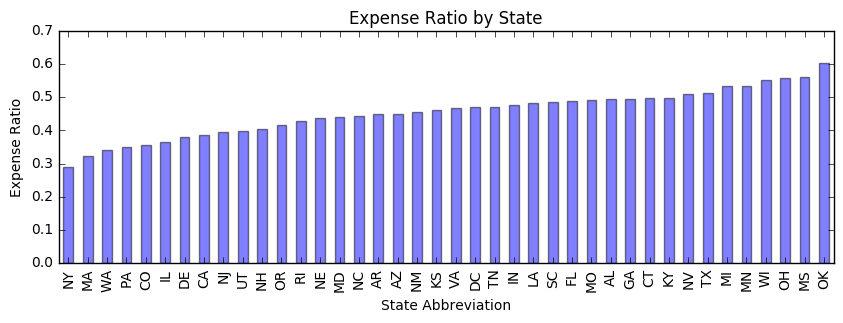

In [12]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

# Use the dataframe with the states' column to calculate necessary aggregate
erData = pd.concat([dataStateAgg['Total Operating Expenses']/dataStateAgg['Effective Gross Income'], 
          dataStateAgg['State Abbreviation']], axis=1).groupby('State Abbreviation', as_index=True) \
    .mean()

plot1 = erData.sort_values(by=[0], ascending=True).plot.bar(
    title='Expense Ratio by State', legend=False, width=0.5, alpha=0.5, figsize=(10,3))
plt.ylabel('Expense Ratio')

There's quite a bit of variation in the expense ratio between states, from slightly under 0.3 to greater than 0.6!

### Next, let's look at the relationship between property age and expenses. 

We will use line graphs to plot the average expense ratio as a function of property age for all available expenses. It is good to normalize expenses like this in order to control for property value and get at the relationship between expenses and age.

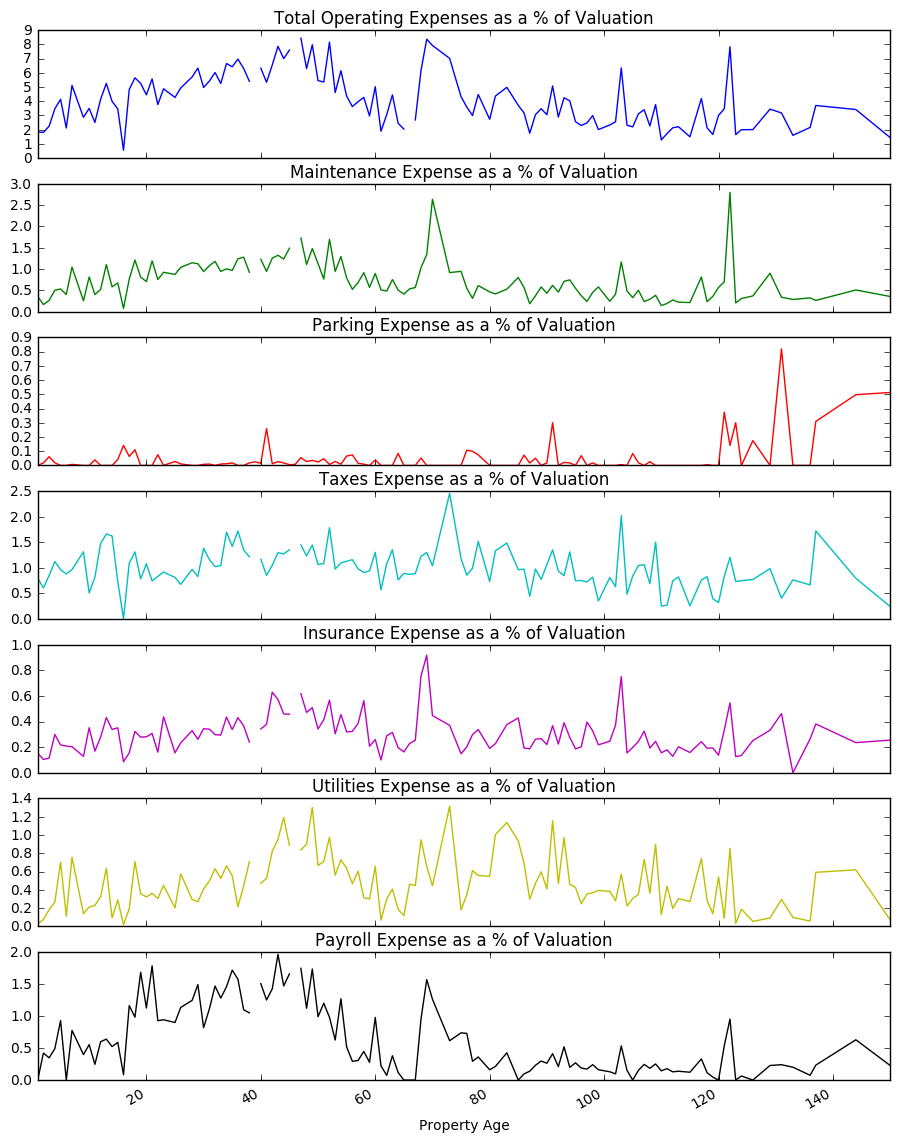

In [13]:
import datetime as dt

ageData = pd.concat([dt.datetime.now().year - data['Year Built']
                     , data.iloc[:,8:]], axis=1)

ageData.iloc[:,1:] = (ageData.iloc[:,1:].div(data['Property Value'], axis=0)*100)

plot2Titles = list(ageData.columns.values[1:] + ' as a % of Valuation')

ageData.groupby('Year Built').mean() \
    .plot.line(subplots=True, figsize=(11,15), legend=False, title=plot2Titles)
plt.xlabel('Property Age')

Some of the expenses seem to increase in relation to property valuation as the property ages (e.g., payroll expense, utilities, insurance, maintenance, total operating), but only to a certain extent. In very old properties, the expense ratio decreases. Note that there are gaps in the data: this occurs when data is not available, and that year is dropped. I chose not to backfill this with the mean or median of the rest of the data, as that would be 1. misleading, and 2. I would want to see where the gaps are and go back to the source (ask an expert/the supplier/s) of the data before moving on. I also chose not to smooth the visualization (say, with a spline) because I view this as an exploratory exercise, and I want to get an idea of how "rough" the data is. Clearly, there is a lot of unexplained variance in the relationship between age and expense ratio.

### Now, we will look at the value of the loans outstanding over time (by fiscal quarter). 

First, we will need to convert the 2 date columns to datetime format. Then we'll write a function to find the cumulative value of each loan in each quarter. Then we'll sum these together and plot it.

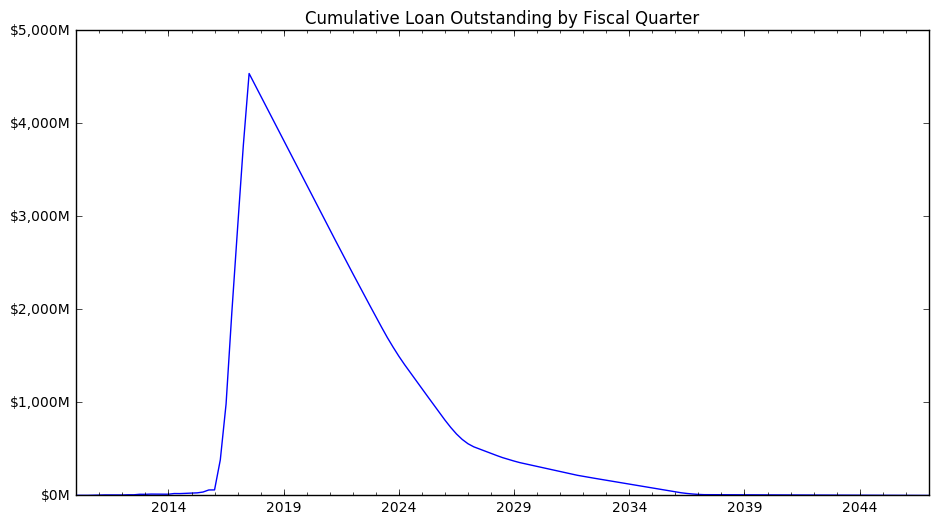

In [14]:
dataCla = data.iloc[:,:3].dropna()

def dateQtrExplode(df):
    dtRng = pd.date_range(df['First Payment Date'], df['Maturity Date'], freq='QS')
    qtrUnit = [(df['Loan Amount'] - (df['Loan Amount']/len(dtRng))*(x+1))/1E6 for x in range(len(dtRng))]
    return pd.Series(qtrUnit, index=dtRng)

fig, ax = plt.subplots(1, 1)

dataCla.apply(dateQtrExplode, axis=1).sum() \
    .plot.line(figsize=(11,6), legend=False
               , title='Cumulative Loan Outstanding by Fiscal Quarter')
    
import matplotlib.ticker as mtick # For formatting y-axis

tick = mtick.StrMethodFormatter('${x:,.0f}M')
ax.yaxis.set_major_formatter(tick)


I've assumed here that people will pay off the outstanding value linearly up to the maturity date, and that no one will default. Notice that the outstanding value peaks near the end of 2017 - that's because we can't factor in future loans that have not been added to the portfolio yet! So the outstanding amount will only decrease after the latest first payment date. Notice also that the slope changes into 2028. These loans are being paid off at a slower rate over a longer period of time.

# Machine Learning
### Predicting LTV
Now, let's create a model to predict LTV (loan-to-value). We should first see what the distribution of LTV is first before going with a model.

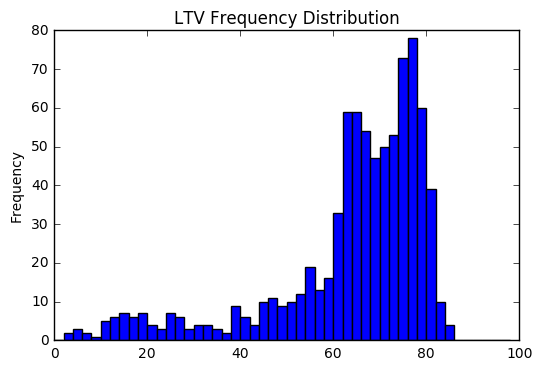

In [15]:
import numpy as np
dataLTV = dataLTV[dataLTV['LTV'] <= 100]
dataLTV['LTV'].plot.hist(bins=[x*2 for x in range(0,50)], title='LTV Frequency Distribution')

This variable is a transformed ratio in the range of 0 - 100. There is a hard cutoff at 100, assuming you never loan more than the value of the collateral (property). This continuous, constrained variable may do well with a generalized linear model using the logit link function. Let's transform LTV to a ratio between 0 and 1, split the data into a train and test set, train a model, and gauge performance. We have a small dataset and relatively few potential input variables. We don't want to throw every variable at a model and see what "sticks" (due to the potential challenge of multicolinearity), so let's first look at the correlations of our other variables to LTV and see which might have a strong (linear) relationship.

In [16]:
dataLTV.corr('pearson')['LTV']

Loan Amount                 0.182217
Zip                        -0.250558
Property Value             -0.091677
Year Built                 -0.101722
Net Operating Income       -0.001767
Effective Gross Income     -0.016782
Total Operating Expenses   -0.037338
Maintenance Expense        -0.043175
Parking Expense            -0.016088
Taxes Expense              -0.046032
Insurance Expense          -0.040605
Utilities Expense          -0.106929
Payroll Expense            -0.004553
LTV                         1.000000
Name: LTV, dtype: float64

First - note that zip code has the strongest (negative) correlation, but the order of zip codes has no meaning per se! This is a good reminder to not blindly throw variables into a machine learning blender. I also suspect that year built would be better expressed as "age". Next, let's note that we've looked at the correlation of raw values to a ratio. Maybe if we expressed those raw expenses as ratios themselves (say, of gross income, or to total operating expenses), we might get a better result. Also, when using linear models, it's a good idea to experiment with rescaling the dependent variables to see if a linear relationship becomes stronger. We will do these correlations and sort them in order to compare our results.

In [17]:
dataLTV.insert(loc = 5, column = 'Age in Years'
               , value = dt.datetime.now().year - dataLTV['Year Built'])
dataLTV.insert(loc = 5, column = 'Loan Expected Lifetime in Days'
               , value = (dataLTV['Maturity Date']-dataLTV['First Payment Date'])/pd.Timedelta(days=1))
# Let's take a look
dataLTV.head(n=2)

,First Payment Date,Maturity Date,Loan Amount,Zip,Property Value,Loan Expected Lifetime in Days,Age in Years,Year Built,Net Operating Income,Effective Gross Income,Total Operating Expenses,Maintenance Expense,Parking Expense,Taxes Expense,Insurance Expense,Utilities Expense,Payroll Expense,LTV
0,2017-06-01,2022-05-01,2143864.02,60077,3003400.25,1795.0,53.0,1965.0,153643.96,282027.80,125597.78,18793.51,4608.95,41580.76,9110.30,11233.91,12215.12,71.381229
1,2017-06-01,2037-05-01,1445991.78,33441,1798349.25,7274.0,58.0,1960.0,105282.69,180649.26,75213.72,14200.86,0.00,32705.82,13001.24,0.00,0.00,80.406616


In [18]:
# Now for the correlations with LTV
dataLtvTrans = pd.concat([dataLTV.iloc[:,4:-1]\
               .rename(columns={x:'NoTransform ' + x for x in list(dataLTV)[4:-1]})
           , dataLTV.iloc[:,4:-1].div(dataLTV.iloc[:,4]+1,axis=0)\
               .rename(columns={x:'PropValueRatio ' + x for x in list(dataLTV)[4:-1]})
           , dataLTV.iloc[:,4:-1].div(dataLTV.iloc[:,10]+1,axis=0)\
               .rename(columns={x:'OpExpRatio ' + x for x in list(dataLTV)[4:-1]})
           , dataLTV.iloc[:,4:-1].apply(np.log)\
               .rename(columns={x:'LogTransformed ' + x for x in list(dataLTV)[4:-1]})
           , dataLTV.iloc[:,4:-1].apply(lambda x: x**2)\
               .rename(columns={x:'Squared ' + x for x in list(dataLTV)[4:-1]})
           , dataLTV.iloc[:,-1]
          ], axis=1)
dataLtvTransCorr = dataLtvTrans.corr('pearson')
dataLtvTransCorr['LTV'][:-1].sort_values()

PropValueRatio Property Value                   -0.201398
LogTransformed Property Value                   -0.184216
LogTransformed Maintenance Expense              -0.150909
OpExpRatio Property Value                       -0.148820
LogTransformed Total Operating Expenses         -0.135692
LogTransformed Taxes Expense                    -0.133988
LogTransformed Utilities Expense                -0.129500
OpExpRatio Year Built                           -0.126088
OpExpRatio Loan Expected Lifetime in Days       -0.123776
LogTransformed Effective Gross Income           -0.117321
LogTransformed Payroll Expense                  -0.107998
NoTransform Utilities Expense                   -0.106929
LogTransformed Year Built                       -0.102293
NoTransform Year Built                          -0.101722
Squared Year Built                              -0.101137
LogTransformed Net Operating Income             -0.096455
LogTransformed Parking Expense                  -0.091796
NoTransform Pr

Now here are some interesting correlations! The ratio of net operating income to property value is the strongest, at 0.320, yet the correlation with the untransformed version of the value is almost nonexistant. This scaling has managed to transform some of the variables into more useful features for a linear model. At the very least, this shows that the simple feature engineering done here was not in vain. <br><br> Also note that high correlation value of the ratios to year built. Note that if we wanted to use a more complicated model, like a neural network, this may not be necessary. Linear models have the advantage of speed, and less risk of overfitting, especially with smaller datasets. 

Let's investigate how some of the best candidate variables from above correlate with each other. A high correlation does not necessarily guarantee multicolinearity, but it can suggest interesting relationships to investigate later. My cutoff is 0.15 for the absolute value of the correlation.

In [19]:
promisingVars = dataLtvTransCorr['LTV'][:-1][np.absolute(dataLtvTransCorr['LTV'][:-1]) > 0.15]\
    .keys().tolist()
dataLtvTransCorr.loc[promisingVars, promisingVars].iloc[:,:-1]

,NoTransform Loan Expected Lifetime in Days,PropValueRatio Property Value,PropValueRatio Loan Expected Lifetime in Days,PropValueRatio Age in Years,PropValueRatio Year Built,PropValueRatio Net Operating Income,LogTransformed Property Value,LogTransformed Loan Expected Lifetime in Days
NoTransform Loan Expected Lifetime in Days,1.000000,-0.304766,0.644676,0.363379,0.295862,-0.183427,-0.386848,0.983759
PropValueRatio Property Value,-0.304766,1.000000,-0.870270,-0.843569,-0.996997,0.022113,0.890896,-0.303644
PropValueRatio Loan Expected Lifetime in Days,0.644676,-0.870270,1.000000,0.826214,0.867958,-0.098705,-0.789500,0.635900
PropValueRatio Age in Years,0.363379,-0.843569,0.826214,1.000000,0.832229,-0.118288,-0.742536,0.357953
PropValueRatio Year Built,0.295862,-0.996997,0.867958,0.832229,1.000000,-0.014542,-0.886721,0.295824
PropValueRatio Net Operating Income,-0.183427,0.022113,-0.098705,-0.118288,-0.014542,1.000000,0.016868,-0.171474
LogTransformed Property Value,-0.386848,0.890896,-0.789500,-0.742536,-0.886721,0.016868,1.000000,-0.374457
LogTransformed Loan Expected Lifetime in Days,0.983759,-0.303644,0.635900,0.357953,0.295824,-0.171474,-0.374457,1.000000
LogTransformed Maintenance Expense,-0.553499,0.702629,-0.747890,-0.680855,-0.695852,0.350574,0.772837,-0.539828


One of these variables does not make much sense. The ratio of property value to itself is 1. I added 1 to the denominator here to ensure there was no division by 0, but apparently this small difference led to some information being preserved. Note the correlation of > 0.89 with the log transformed version of the variable, indicating that scaling property value by itself + 1 and logarithmically achieve similar goals. It makes more theoretical sense to keep just the log transformed version, even though the correlation with LTV is slightly weaker. <br><br>
Let's use all of these most promising variables as input to a model. We'll do a train/test split (initialized with a seed), then train a random forest regression (initialized with the same seed).
#### Model choice
The model choice deserves a little discussion. Because the data is continuous within a certain range. It would be most proper to use a beta regression. However, there's no easy implementation of this in Python that I could find (it exists in R). <br><br>
Therefore, I elected to use a random forest regression as the predicted values will never exceed the highest value in the training data. This is because random forest regression makes predictions through averaging values at different tree nodes and trees. And in any case, there's no guarantee that the distribution of values outside the range of the train set is identical to those within the range. This probably applies to LTV - the characteristics that lead to an LTV of 90 are perhaps quite different from those that lead to an LTV of 20. <br><br>
Beyond this, random forests require little tuning and are resistant to overfitting except with very very noisy data. They can also find non-linear patterns. It's a good, uncomplicated start. <br><br>
But enough theorizing.

In [20]:
#promisingVars.remove('PropValueRatio Property Value')

allPromisingVars = promisingVars + ['LTV']

mlDataPromising = (dataLtvTrans.loc[:, allPromisingVars]).replace([np.inf, -np.inf], np.nan).dropna()

def randomSplitter(pro, dta):
    np.random.seed(786) # For reproducibility
    return [x <= pro for x in np.random.random_sample(len(dta)).tolist()]

subsetVectorP = randomSplitter(0.8, mlDataPromising)

mlDataPromisingTrain = mlDataPromising.iloc[subsetVectorP,:]

print('Number of rows in the train dataset: ', len(mlDataPromisingTrain))

mlDataPromisingTest = mlDataPromising.iloc[np.invert(subsetVectorP),:]

Number of rows in the train dataset:  619


In [21]:
from sklearn.ensemble import RandomForestRegressor
RFfitter = RandomForestRegressor(n_estimators = 1000, max_depth=7, oob_score = True
                                 , max_features='log2', random_state=786)
RFfitter.fit(mlDataPromisingTrain.iloc[:,:-1], mlDataPromisingTrain.iloc[:,-1])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=True, random_state=786, verbose=0, warm_start=False)

In [22]:
print('OOB Score (i.e., R^2, explained variance): ', RFfitter.oob_score_)

OOB Score (i.e., R^2, explained variance):  0.510273878388


In [23]:
featImp = pd.Series(dict(zip(list(mlDataPromisingTrain)[:-1], RFfitter.feature_importances_)))
print('Feature Importance:') 
print(featImp.sort_values())

Feature Importance:
PropValueRatio Property Value                    0.000624
PropValueRatio Age in Years                      0.055643
PropValueRatio Year Built                        0.067265
LogTransformed Property Value                    0.071241
LogTransformed Maintenance Expense               0.076437
PropValueRatio Loan Expected Lifetime in Days    0.087261
NoTransform Loan Expected Lifetime in Days       0.194807
LogTransformed Loan Expected Lifetime in Days    0.198221
PropValueRatio Net Operating Income              0.248501
dtype: float64


In [24]:
mdlR2 = RFfitter.score(mlDataPromisingTest.iloc[:,:-1], mlDataPromisingTest.iloc[:,-1])
print('Model Test Set R^2 (explained variance): ', mdlR2)

Model Test Set R^2 (explained variance):  0.447736463482


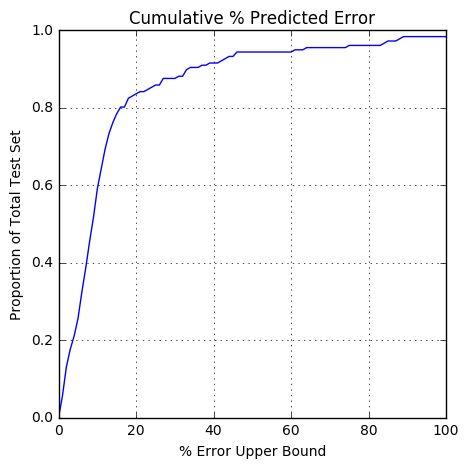

In [25]:
testSetPerf = pd.DataFrame([RFfitter.predict(mlDataPromisingTest.iloc[:,:-1])
                            , mlDataPromisingTest.iloc[:,-1]]) \
    .T.rename(columns={0:'Pred', 1:'Ref'})
def errorPcnt(pred,ref):
    return np.absolute((pred - ref)/ref)
testSetPerf['ErrorPcnt'] = errorPcnt(testSetPerf.iloc[:,0], testSetPerf.iloc[:,1])  
testPerfData = {x:np.sum(testSetPerf.iloc[:,2] <= (x/100.0))/len(testSetPerf) for x in range(0,101)}
testPerfData = pd.DataFrame.from_dict(testPerfData, orient='index')
testPerfData.plot.line(
    grid=True
    , legend=False
    , figsize=(5,5)
    , title='Cumulative % Predicted Error')
plt.xlabel('% Error Upper Bound')
plt.ylabel('Proportion of Total Test Set')

In [26]:
print('Test Set PPE20: ', testPerfData[0][20])

Test Set PPE20:  0.835227272727


Here, I have shown 3 different ways to calculate and demonstrate accuracy. They say different things, and some are preferable to others depending on the situation. The first is out-of-bag R^2 (the coefficient of variation, aka the % of variance in the dependent variable explained). Out of bag calculations were developed for ensemble models like random forests, and are essentially a method to assess model performance without a test set. A decision tree is trained with a certain subset of samples, which are then used to make predictions for all data not in the train subset. These data are averaged together at the end. This simulates many, overlapping test sets, and has been shown to be as performant as a equal train/test split. If the population distribution follows this sample and stays constant over time, we would expect the model to account for a little over half the observed variance. <br><br>
I also show R^2 on the test set. This performance is lower than the OOB R^2. This might be due to the randomness of the train/test split, as well as the small sample size. One could repeatedly train random forests with different seeds initialized and report how OOB R^2 and test set R^2 vary. <br><br>
R^2 is commonly used, but suffers from some limitations, including making comparisons to the naive mean (what if one wants to use another way, like median, to baseline performance?), and can grow artificially high when more predictors are added to the model. In other words, it can mask the negative effects of "kitchen sink" modeling (i.e., haphazardly throwing every variable you have at the problem).<br><br>
The last way (the graph) is my preference for demonstrating accuracy. This is a measure called percent predicted error (or PPEx, where x is the % error upper bound). This shows the % of the test set that is within a certain % of the reference (ground truth) value. I plotted it for 0% - 100% in increments of 1 (error can be greater than 100%, but very little data is in that echelon here). Note that over 80% of predictions are within 20% of the actual value, and over half are within 10%. Not only is PPE intuitive, but the threshold can be adjusted based on business need. If, for example, a client values very precise predictions, report PPE5 (the % of predictions within 5% of the actual value). I report PPE20 at 83.5%. The point estimate most related to the PPE graph (besides choosing a cutoff) is MAD (mean or median absolute deviation), but the graph is much more informative about the distribution of errors. One could even calculate the area under the curve to select better models. A perfect model would have an area of 100 here, i.e. the whole square.
### Improving model performance
There are many, many ways to improve the performance of this model. Introducing an OOB cross-validation procedure could help to fine tune the hyperparameters to maximize performance (OOB score) while optimizing computational performance. Some of the params include tree depth, purity criteria, and # of trees.<br><br>
Even before the model, one could engineer new and different features that might be more informative, like expressing even more of the current variables as ratios of each other. I could try to add more variables from my feature selection process into the model blender. The correlation cutoff I used for the feature selection could even be a tunable parameter! I could use a dimensionality reduction technique like PCA to account for correlated variables and make the model potentially more robust. <br><br>
Different models could be used. The random forest could be combined with different models to form an ensemble. The ensemble could use voting, or use machine learning to make blended predictions. Gradient boosting could improve performance (e.g., xgBoost). Gradient boosting requires more tuning, but can usually achieve better performance than random forest. <br><br>
If I had to pick an order in which to do these, I would start with feature engineering, and then train a different, unrelated model to see if there are potential synergies through ensembling. The time spent fine-tuning hyperparameters for one model often leads to diminishing returns relative to other activities. <br><br>
Before doing any of this, though, we should always ask whether it's necessary for the business. It's best to start out with as simple an approach as possible and then iterate on it with an eye directed outwards. Remember, the so-called "weak" models you develop in the beginning might make a fantastic input into an ensemble later!